In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
file_path = 'ML_DATABASE/OUTPUT.csv'

In [3]:
data = pd.read_csv(file_path)


In [4]:
data.head()

,JOB_NUM,Q1,Q2,Q3,EN,SN,FN,F,M,ORIG_MAPE,MAPE1,MAPE2,WMAPE,KAPPA,SIM_TIME,Unnamed: 15
0,1,0.9,0.9,0.81,0.25,0.1,0.03,0.0013,0.0,21.51735,1.67961,42.58448,43.42429,NaN,0.2,NaN
1,2,0.9,0.9,0.81,0.25,0.1,0.09,0.0015,1100.0,7.01888,1.80356,12.56888,13.47066,NaN,0.1,NaN
2,3,0.9,0.9,2.56,0.40,0.2,0.03,0.0013,0.0,20.26448,1.67056,40.01095,40.84623,NaN,0.2,NaN
3,4,0.9,1.1,0.81,0.40,0.2,0.03,0.0015,1100.0,7.67506,1.67798,14.05515,14.89414,NaN,0.1,NaN
4,5,0.9,1.1,2.56,0.25,0.2,0.09,0.0013,1100.0,7.06896,2.10980,12.34779,13.40269,NaN,0.2,NaN


In [5]:
data = data.drop(columns='Unnamed: 15')

In [6]:
# Extract the first 12 rows to determine the range of each parameter
parameter_ranges = data.iloc[:12][['Q1', 'Q2', 'Q3', 'EN', 'SN', 'FN', 'F', 'M']]


In [7]:
# Determine the min and max values for each parameter
min_values = parameter_ranges.min().values
max_values = parameter_ranges.max().values

In [8]:
min_values

array([0.9   , 0.9   , 0.81  , 0.25  , 0.1   , 0.03  , 0.0013, 0.    ])

In [9]:
max_values

array([1.60e+00, 1.10e+00, 2.56e+00, 4.00e-01, 2.00e-01, 9.00e-02,
       1.50e-03, 1.10e+03])

In [8]:
X = data[['Q1','Q2','Q3','EN','SN','FN','F','M']]

In [9]:
y = data['ORIG_MAPE']

In [10]:
# 3. Train the Random Forest Regressor using Grid Search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 4. Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# 5. Predict and evaluate the model on the test set
y_pred_test = rf_model.predict(X_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f'Initial Test MAPE: {mape_test}')

Initial Test MAPE: 0.09072094928059679


In [14]:
# Generate a new set of parameters within the specified range
def generate_parameters(n_samples, min_values, max_values):
    # min_values = min_values.values
    # max_values = max_values.values
    random_parameters = np.random.rand(n_samples, len(min_values)) * (max_values - min_values) + min_values
    return pd.DataFrame(random_parameters, columns=['Q1', 'Q2', 'Q3', 'EN', 'SN', 'FN', 'F', 'M'])

In [15]:
# Generate 100 new parameter sets as an example
n_samples = 100
new_parameters = generate_parameters(n_samples, min_values, max_values)

In [16]:
# 7. Predict ORIG_MAPE for each new set of parameters using the trained model
predicted_mape_new = rf_model.predict(new_parameters)

In [17]:
# 8. Find the parameter set with the lowest ORIG_MAPE
min_mape_index = np.argmin(predicted_mape_new)
optimal_parameters = new_parameters.iloc[min_mape_index]
min_mape_value = predicted_mape_new[min_mape_index]

In [18]:

print(f'Optimal Parameters:\n{optimal_parameters}')
print(f'Minimum Predicted ORIG_MAPE: {min_mape_value}')

Optimal Parameters:
Q1      0.997103
Q2      1.057278
Q3      2.372019
EN      0.355154
SN      0.195899
FN      0.040536
F       0.001306
M     722.380346
Name: 9, dtype: float64
Minimum Predicted ORIG_MAPE: 4.095121999999997


In [19]:
# Initialize the model
rf1 = RandomForestRegressor(random_state=42)

In [20]:
# Grid Search to find the best parameters
grid_search = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X, y)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [21]:
# Best parameters from Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [22]:
# Convert to DataFrame to display the optimal parameters
optimal_parameters_df = pd.DataFrame([best_params])
print(f'Optimal Parameters:\n{optimal_parameters_df}')

Optimal Parameters:
   max_depth  min_samples_leaf  min_samples_split  n_estimators
0         20                 1                  5           300


In [23]:
# 4. Generate a set of optimal parameters
optimal_parameters_df = pd.DataFrame([best_params])
print(f'Optimal Parameters:\n{optimal_parameters_df}')

Optimal Parameters:
   max_depth  min_samples_leaf  min_samples_split  n_estimators
0         20                 1                  5           300


In [24]:

# 5. Predict ORIG_MAPE for the optimal parameters
optimal_pred = best_model.predict(X)
optimal_mape = mean_absolute_percentage_error(y, optimal_pred)



In [25]:
print(f'MAPE for Optimal Parameters: {optimal_mape}')

MAPE for Optimal Parameters: 0.05162246007042375


In [26]:
# Create a pipeline with normalization and Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize the data
    ('rf', RandomForestRegressor(random_state=42))  # Train the Random Forest Regressor
])

In [27]:
# Define the parameter grid for Grid Search
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}


In [28]:
# Grid Search to find the best parameters
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X, y)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20, 30],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [29]:
# Generate more samples (e.g., 1000 samples)
n_samples = 100

def generate_parameters(n_samples, min_values, max_values):
    random_parameters = np.random.rand(n_samples, len(min_values)) * (max_values - min_values) + min_values
    return pd.DataFrame(random_parameters, columns=['Q1', 'Q2', 'Q3', 'EN', 'SN', 'FN', 'F', 'M'])


In [30]:
# Generate the larger set of parameters
new_parameters = generate_parameters(n_samples, min_values, max_values)


In [31]:
# Use the best model to predict MAPE for these new samples
predicted_mape_new = grid_search.best_estimator_.predict(new_parameters)


In [32]:
# Add the predicted MAPE to the DataFrame and sort to find the top-performing samples
new_parameters['Predicted_MAPE'] = predicted_mape_new
top_parameters_df = new_parameters.sort_values(by='Predicted_MAPE')

In [33]:
# Display the top 10 parameters
print(f'Top 10 Optimal Parameters:\n{top_parameters_df}')

Top 10 Optimal Parameters:
          Q1        Q2        Q3        EN        SN        FN         F  \
36  1.168143  1.034815  2.000428  0.367562  0.187020  0.041936  0.001308   
41  0.952726  0.989078  1.236483  0.388892  0.151999  0.032255  0.001400   
28  1.320192  0.936846  1.402395  0.302710  0.134501  0.033730  0.001308   
12  1.243518  1.053765  1.507125  0.258821  0.153422  0.070253  0.001411   
53  1.527870  0.941494  1.646289  0.333437  0.151606  0.077200  0.001422   
..       ...       ...       ...       ...       ...       ...       ...   
71  1.100617  0.916277  1.011263  0.328199  0.188119  0.067430  0.001481   
86  0.942682  1.008630  1.508509  0.345132  0.198103  0.087988  0.001431   
87  1.363261  1.095820  2.146348  0.394355  0.107516  0.081269  0.001393   
79  1.515643  0.962180  1.892436  0.338008  0.128233  0.087049  0.001317   
68  1.291963  0.997282  2.507568  0.287177  0.176437  0.085687  0.001499   

             M  Predicted_MAPE  
36  664.788304        4.408

In [34]:
# Save the top 10 optimal parameters to a CSV file
output_file_path = 'top_10_optimal_parameters.csv'
top_parameters_df.to_csv(output_file_path, index=False)

In [35]:
#Co-relation between parameters: 
#Input column: 'Q1', 'Q2', 'Q3', 'EN', 'SN', 'FN', 'F', 'M'
#Ouput column: 'ORIG_MAPE'
# Extract the relevant columns for analysis
columns_of_interest = ['Q1', 'Q2', 'Q3', 'EN', 'SN', 'FN', 'F', 'M', 'ORIG_MAPE']
data_selected = data[columns_of_interest]

In [36]:
# Calculate the correlation matrix to analyze relationships
correlation_matrix = data_selected.corr()

In [37]:
print(correlation_matrix)


                 Q1        Q2        Q3        EN        SN        FN  \
Q1         1.000000 -0.061349 -0.002364 -0.049629 -0.015912  0.097458   
Q2        -0.061349  1.000000 -0.050275  0.094467  0.022959 -0.082983   
Q3        -0.002364 -0.050275  1.000000  0.137130  0.037276  0.059648   
EN        -0.049629  0.094467  0.137130  1.000000  0.041462 -0.029639   
SN        -0.015912  0.022959  0.037276  0.041462  1.000000  0.006795   
FN         0.097458 -0.082983  0.059648 -0.029639  0.006795  1.000000   
F          0.036482 -0.076077  0.008811 -0.000043  0.021194 -0.067842   
M         -0.073664 -0.015381 -0.341704  0.010943 -0.081663  0.030029   
ORIG_MAPE  0.156959 -0.041859  0.471096 -0.024868  0.069514  0.076840   

                  F         M  ORIG_MAPE  
Q1         0.036482 -0.073664   0.156959  
Q2        -0.076077 -0.015381  -0.041859  
Q3         0.008811 -0.341704   0.471096  
EN        -0.000043  0.010943  -0.024868  
SN         0.021194 -0.081663   0.069514  
FN        -

In [38]:
correlation_matrix['ORIG_MAPE'].sort_values(ascending=False)

ORIG_MAPE    1.000000
Q3           0.471096
Q1           0.156959
FN           0.076840
SN           0.069514
F            0.051084
EN          -0.024868
Q2          -0.041859
M           -0.793291
Name: ORIG_MAPE, dtype: float64

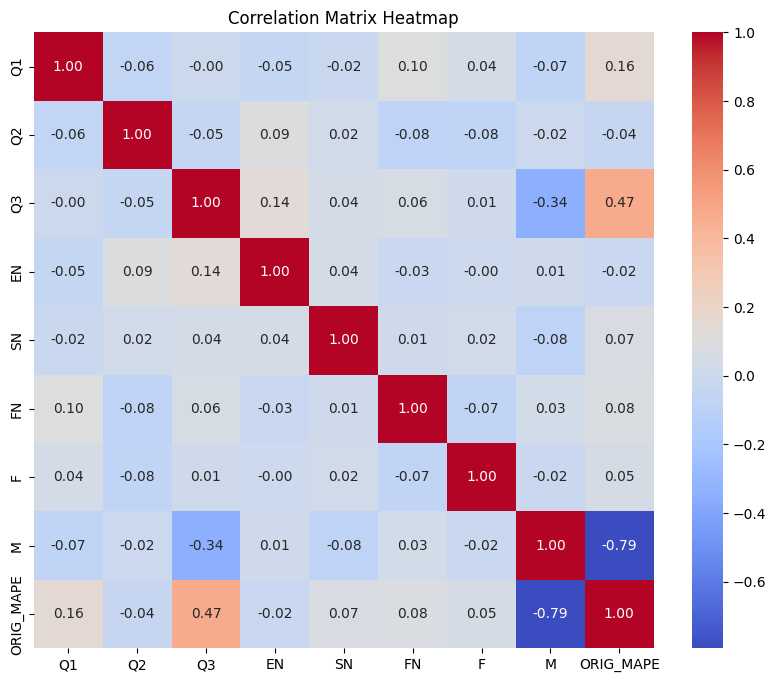

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()